In [26]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt


#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
#read the file with the labels and the metadata
ids = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "subforum_id","num_contexts", "label"]]
ids.head()

,file_id,subforum_id,num_contexts,label
0,12834217_1,1346,0,noHate
1,12834217_2,1346,0,noHate
2,12834217_3,1346,0,noHate
3,12834217_4,1346,0,hate
4,12834217_5,1346,0,noHate


In [31]:
def get_data(paths):
  
    sets = []
    for p in paths:

        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            sets.append((file_id, f.read()))

    return pd.DataFrame(sets, columns=["file_id", "text"])


In [32]:
import glob
df = get_data(glob.glob('./hate-speech-dataset/all_files/*.txt'))

df.head()

,file_id,text
0,13458115_2,It 's like that at most public boards .
1,13367480_1,I wonder if one of the victims opened the door...
2,30422449_1,Some people believe the Jack O ' Lantern also ...
3,14651837_4,Ready .... GO !!!
4,30527903_3,Thanks !


In [33]:
data = df.join(ids.set_index('file_id'), on='file_id')

data.head()

,file_id,text,subforum_id,num_contexts,label
0,13458115_2,It 's like that at most public boards .,1347,0,noHate
1,13367480_1,I wonder if one of the victims opened the door...,1345,0,noHate
2,30422449_1,Some people believe the Jack O ' Lantern also ...,1348,0,noHate
3,14651837_4,Ready .... GO !!!,1371,0,noHate
4,30527903_3,Thanks !,1359,0,noHate


In [34]:
data = data[data.label != 'relation']
data =  data[data.label != 'idk/skip']

In [35]:
X = data.iloc[:, [1,2,3]]
y = data['label']


In [36]:
X.head()

,text,subforum_id,num_contexts
0,It 's like that at most public boards .,1347,0
1,I wonder if one of the victims opened the door...,1345,0
2,Some people believe the Jack O ' Lantern also ...,1348,0
3,Ready .... GO !!!,1371,0
4,Thanks !,1359,0


In [37]:

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
X['text']= df['text'].apply(lambda x: remove_punctuations(x))
X.head()

,text,subforum_id,num_contexts
0,It s like that at most public boards,1347,0
1,I wonder if one of the victims opened the door...,1345,0
2,Some people believe the Jack O Lantern also r...,1348,0
3,Ready GO,1371,0
4,Thanks,1359,0


In [38]:
#Remove stop words from the text 
#notice, words like is, s and that at etc are removed
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
 
        if word not in stop_words:
 
            # Let's Lemmatize the word as well
            # before appending to the imp_words list.
 
            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word)
 
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output

X['text'] = X['text'].apply(lambda text: remove_stopwords(text))
X.head()

,text,subforum_id,num_contexts
0,It like public boards,1347,0
1,I wonder one victims opened door apartment reason,1345,0
2,Some people believe Jack O Lantern also repres...,1348,0
3,Ready GO,1371,0
4,Thanks,1359,0


In [39]:
#make all text lower case
X['text'] = X['text'].str.lower()
X.head()

,text,subforum_id,num_contexts
0,it like public boards,1347,0
1,i wonder one victims opened door apartment reason,1345,0
2,some people believe jack o lantern also repres...,1348,0
3,ready go,1371,0
4,thanks,1359,0


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

<AxesSubplot: >

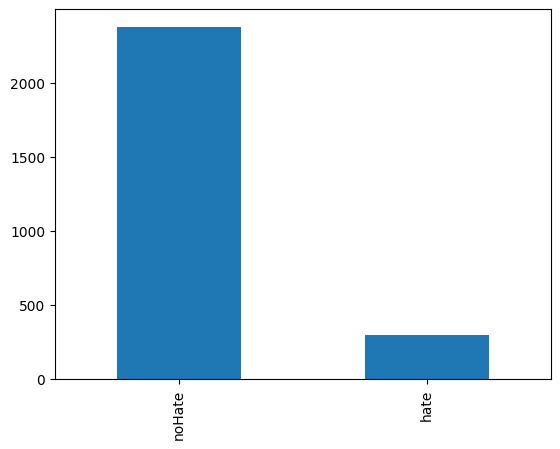

In [41]:
y_test.value_counts().plot(kind='bar')

In [42]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)


In [43]:
#vocab for hate sentences is 4,148 and for non-hate sentences is 13,154
max_words = 10000

#max len of hate sentences is 20.9 + 9, for no-hate it is 15 + 9 
max_len = 30
 
token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')
 
token.fit_on_texts(X_train['text'])

In [44]:
# # Convert the text feature into a vectors of tokens
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
#                              lowercase=True, stop_words='english')
# X_train_cv = cv.fit_transform(X_train)
# X_test_cv = cv.transform(X_test)


In [45]:
#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train['text'])
Training_pad = pad_sequences(Training_seq,
                             maxlen=30,
                             padding='post',
                             truncating='post')
 
Testing_seq = token.texts_to_sequences(X_test['text'])
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=30,
                            padding='post',
                            truncating='post')

In [51]:
y_train

,hate,noHate
10626,1,0
561,0,1
1727,0,1
4606,0,1
3531,0,1
...,...,...
4847,0,1
10116,1,0
4346,0,1
6450,0,1


In [54]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(Training_pad, y_train.values[:,0])
predictions = clf.predict(Testing_pad)

In [57]:
# Plot scores and make a confusion matrix for non-hate/hate predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.values[:,0], predictions)

print(f'Number of samples to classify: {len(X_test)}\n')
print(f'Accuracy score: {accuracy_score(y_test.values[:,0], predictions)}')
# print(f'Precision score: {precision_score(y_test, predictions)}')
#print(f'Recall score: {recall_score(y_test, predictions)}\n')
print(f'Confusion matrix: \n{cm}')

Number of samples to classify: 2676

Accuracy score: 0.7193572496263079
Confusion matrix: 
[[1802  575]
 [ 176  123]]


Text(47.222222222222214, 0.5, 'True label')

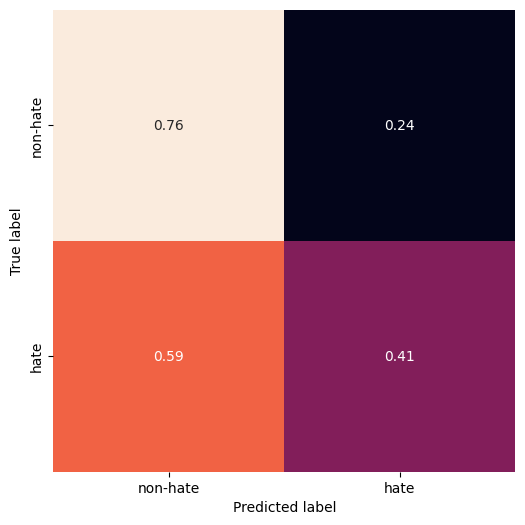

In [58]:
import seaborn as sns
plt.figure(figsize=(6,6))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, square=True, annot=True, cbar=False,
            xticklabels=['non-hate', 'hate'], yticklabels=['non-hate', 'hate'])
plt.xlabel('Predicted label')
plt.ylabel('True label')